In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Custom functions
from utils import *
from backtester import *

In [2]:
%load_ext autoreload
%autoreload 2

## ARIMA forecasting [DAILY]

In [3]:
# Load
corn_raw = pd.read_csv('data/corn.csv', header = 2)

# Process
df = process_data(corn_raw, 'CORN', start_date = '2000-01-01', end_date='2020-01-01') 
#df

## OPTIONAL: Convert to weekly data: 

#### All ACF and PACF lags are not statistically significant...

In [4]:
# # Roughly convert to weekly data. 5 trading days in a week. 
# df = df.iloc[::5, :]
# df

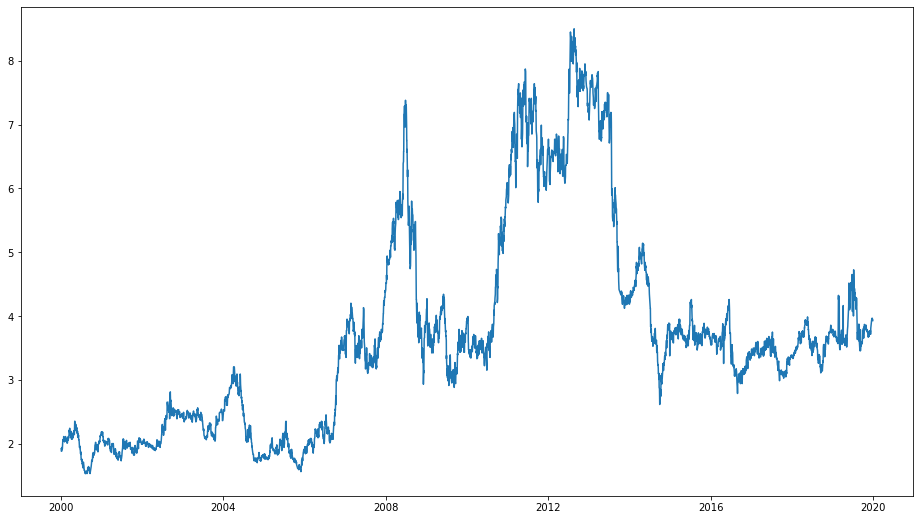

In [5]:
plt.figure(figsize=(16,9))
plt.plot(df.Date, df.CORN)

In [6]:
# Take log values
df.loc[:,"CORN_log"] = np.log(df.CORN)

# Take first order differencing
difference_order = 1
df["CORN_log_diff"] = df.CORN_log.diff(periods=difference_order)

# Drop first row(s) used up in the differencing (they are NaNs for lags < order) 
df = df.drop(index=range(difference_order))

# Reset Index
df = df.reset_index(drop = True)

## First order differencing of log prices

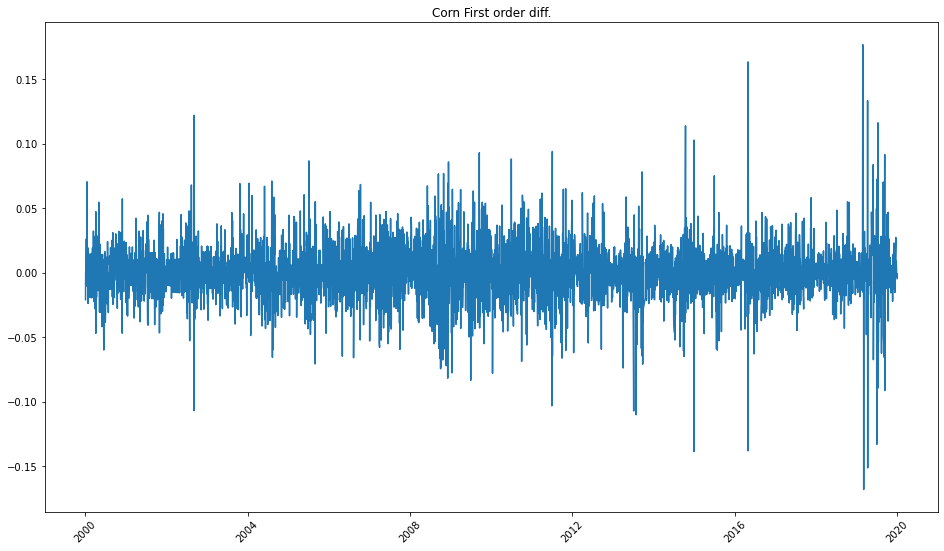

In [14]:
plt.figure(figsize=(16,9))
plt.plot(df.Date, df.CORN_log_diff)
plt.title("Corn First order diff.")
plt.xticks(rotation=45)
plt.show()

## ACF:

In [8]:
acf_coeffs, acf_conf_interval = acf(df.CORN_log_diff, nlags=40, alpha = 0.01)

# We don't care about lag=0, so get rid of those 
acf_coeffs = acf_coeffs[1:]
acf_conf_interval = acf_conf_interval[1:,:]

# Subtract off mean to get error bar value
acf_error_bars = np.abs(acf_conf_interval[:,0] - acf_coeffs)

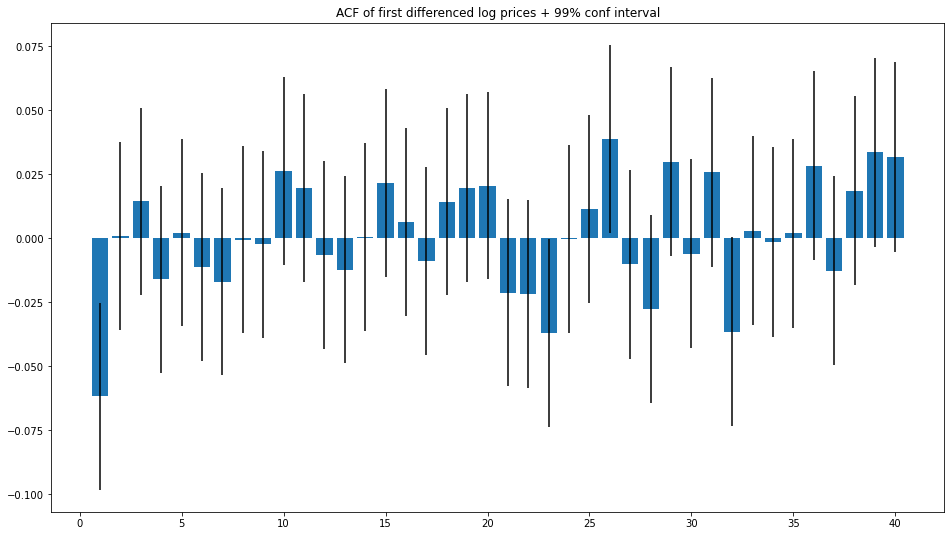

In [9]:
acf_xs = np.arange(1,len(acf_coeffs)+1, 1)
plt.figure(figsize=(16,9))
plt.bar(x=acf_xs, height=acf_coeffs, yerr=acf_error_bars)
plt.title("ACF of first differenced log prices + 99% conf interval")
plt.show()

#### Appear to be statistically significant coefficients at lag = 1, 26

## PACF:

In [12]:
pacf_coeffs, pacf_conf_interval = pacf(df.CORN_log_diff, nlags=40, alpha = 0.01)

# We don't care about lag=0, so get rid of those 
pacf_coeffs = pacf_coeffs[1:]
pacf_conf_interval = pacf_conf_interval[1:,:]

# Subtract off mean to get error bar value
pacf_error_bars = np.abs(pacf_conf_interval[:,0] - pacf_coeffs)

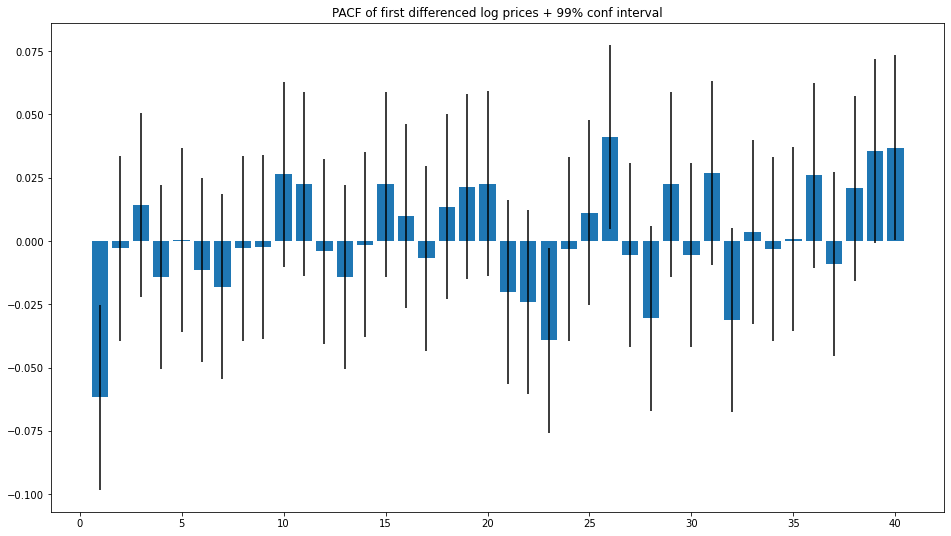

In [13]:
pacf_xs = np.arange(1,len(pacf_coeffs)+1, 1)
plt.figure(figsize=(16,9))
plt.bar(x=pacf_xs, height=pacf_coeffs, yerr=pacf_error_bars)
plt.title("PACF of first differenced log prices + 99% conf interval")
plt.show()

#### Also statistically significant coefficients at lag = 1, 23, 26

In [ ]:
i = 0

training_days = 200

training_df = df.iloc[i:i+training_days]
test_df = df.iloc[i+training_days]

model = ARIMA(training_df.CORN_log, order=(7,1,7))
results = model.fit()    

print(results.summary())
    

plt.plot(results.resid)
plt.title("Time series plot of residuals")
plt.show()

acf_list = acf(results.resid)
plt.bar(np.arange(0,len(acf_list), 1), acf_list)
plt.title("ACF of residuals"); plt.show()
plt.show()


fig = qqplot(results.resid, line  = 's')
plt.title("Q-Q plot of residuals")
plt.show()

LB_stat, LB_stat_p_val = acorr_ljungbox(results.resid, lags=np.arange(1,20,1), return_df = False)
#print("Ljung-Box Statistic: " + str(LB_stat))
#print("Ljung-Box Statistic p-val: " + str(LB_stat_p_val))
plt.bar(np.arange(1,20,1), LB_stat_p_val)
plt.xticks(ticks = np.arange(1,20,1))
plt.ylim([0,1])
plt.title("Ljung-Box Stat p-vals")
plt.show()

### None of the coefficients are statistically significant, not even a little bit. This is concerning, but expected for such a noisy time series.

### While we can take solace in the fact that the ACF of residuals is nearly zero for lags != 0, and that the Ljung-Box Stat p-vals show that all lags are not statistically significant, the Q-Q plot of residuals shows how unsuitable a Gaussian assumption is for our residuals. 

# Simulation
### One week ahead forecasting

In [ ]:
# Rolling window
training_days = 200

true_values = []
predicted_values = []
dates = []

start = 0

## THIS WILL TAKE A LONG TIME
#end = int(df.shape[0] - training_days) / 5 # 5 trading days in a week
end = 4



for i in range(start, end):
    training_df = df.iloc[i:(5*i)+training_days]
    test_df = df.iloc[(5*i)+training_days]
    
    # ARIMA(26,1,26) on log prices
    model = ARIMA(training_df.CORN_log, order=(26,1,26))
    results = model.fit()
    one_week_ahead_forecast = results.get_forecast(5).summary_frame().iloc[-1,0]
    
    true_values.append(test_df.CORN_log)
    predicted_values.append(one_week_ahead_forecast)
    dates.append(test_df.Date)

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(dates, true_values, dates, predicted_values)
plt.legend(["True Values", "Predicted Values"])
plt.title("Corn ARIMA one-step-ahead forecasting")
plt.show()

In [ ]:
backtest(forecast_for_each_day=predicted_values, price_series=true_values)

# Multi-variate version

### Turn into ARIMAX by incorporating other commodities? Dependent: Corn, Independent: Corn, Wheat, Soybean, 